In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import seaborn as sns
import pandas as pd
from keras.datasets import mnist
from icecream import ic
from keras.utils import to_categorical
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
import warnings

np.set_printoptions(linewidth=200, suppress=True, precision=3)

In [43]:
def plot_class_distribution(classes):
    # Suppress all warnings
    warnings.filterwarnings("ignore")

    sns.countplot(x = classes)
    plt.title('Распределение классов')
    plt.xlabel('Цифры')
    plt.show()

    # Reset the warning filter to its default state
    warnings.filterwarnings("default")

def reduce_dataset(X, y, reduce_to):
    # Создать пустые списки для хранения индексов
    idx = []

    # Для каждого класса от 0 до 9
    for i in range(10):
        # Найти индексы примеров, соответствующих данному классу
        idx_i = np.where(y == i)[0]
        # Случайным образом выбрать подмножество индексов
        idx_i = np.random.choice(idx_i, size=reduce_to, replace=False)
        # Добавить индексы в списки
        idx.extend(idx_i)

    # Перемешать индексы
    np.random.shuffle(idx)
    # Сократить датасет с помощью индексов
    return (X[idx], y[idx])

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def cross_entropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    log_likelihood = -np.log(y_pred)
    loss = np.sum(y_true * log_likelihood) / n_samples
    return loss

def derivative_cross_entropy(y_true, y_pred):
    n_samples = y_true.shape[0]
    d_loss = (y_pred - y_true) / n_samples
    return d_loss

X shape (56000, 784)
y shape (56000, 10)


Epoch:   0%|          | 0/29 [00:00<?, ?it/s]

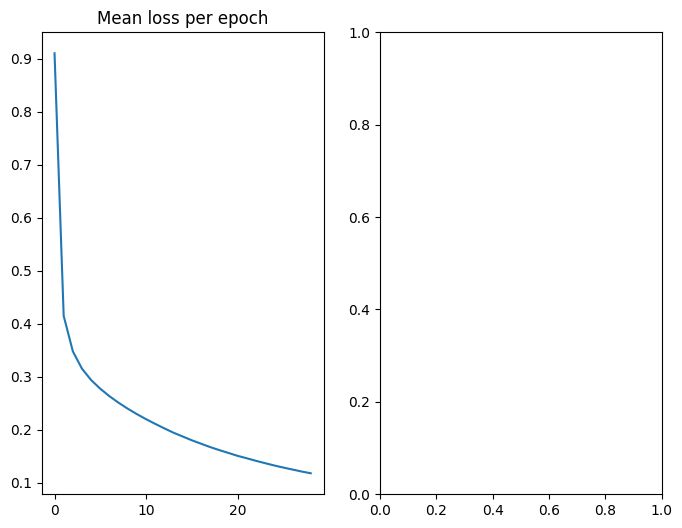

In [47]:
class Layer:
    def __init__(self):
        self.cache = None

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.normal(0, np.sqrt(2/input_size), (input_size, output_size))
        self.bias = np.random.normal(0, 1, (output_size))
        self.gW = 0
        self.gB = 0

    def forward(self, input):
        out = np.dot(input, self.weights) + self.bias
        self.cache = input
        return out

    def backward(self, output_gradient, learning_rate):
        X = self.cache
        # input grad
        dX = np.dot(output_gradient, self.weights.T).reshape(X.shape)
        
        self.gW = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, output_gradient)
        self.gB = np.sum(output_gradient, axis=0)
        
        # update
        self.weights -= learning_rate * self.gW
        self.bias -= learning_rate * self.gB
        return dX

class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input):
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient

class Softmax(Layer):
    def __init__(self):
        self.cache = None

    def forward(self, input):
        maxes = np.amax(input, axis=1)
        maxes = maxes.reshape(maxes.shape[0], 1)
        Y = np.exp(input - maxes)
        Z = Y / np.sum(Y, axis=1).reshape(Y.shape[0], 1)
        self.cache = (input, Y, Z)
        return Z # distribution

    def backward(self, output_gradient, learning_rate):
        X, Y, Z = self.cache
        dZ = np.zeros(X.shape)
        dY = np.zeros(X.shape)
        dX = np.zeros(X.shape)
        N = X.shape[0]
        for n in range(N):
            i = np.argmax(Z[n])
            dZ[n,:] = np.diag(Z[n]) - np.outer(Z[n],Z[n])
            M = np.zeros((N,N))
            M[:,i] = 1
            dY[n,:] = np.eye(N) - M
        dX = np.dot(output_gradient,dZ)
        dX = np.dot(dX,dY)
        return dX

class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.cache = None
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.cache = input
        return self.activation(self.cache)

    def backward(self, output_gradient, learning_rate):
        X = self.cache
        return np.multiply(output_gradient, self.activation_prime(X))

class Tanh(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            return sigmoid(x) * (1 - sigmoid(x))

        super().__init__(sigmoid, sigmoid_prime)

class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.maximum(0, x)

        def relu_prime(x):
            return np.where(x > 0, 1, 0)

        super().__init__(relu, relu_prime)

class Loss:
    def __init__(self) -> None:
        pass

    def get(self, Y_pred, Y_true):
        pass

def NLLLoss(Y_pred, Y_true):
    """
    Negative log likelihood loss
    """
    loss = 0.0
    N = Y_pred.shape[0]
    M = np.sum(Y_pred*Y_true, axis=1)
    for e in M:
        #print(e)
        if e == 0:
            loss += 500
        else:
            loss += -np.log(e)
    return loss/N

class CrossEntropyLoss():
    def __init__(self):
        pass

    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        softmax = Softmax()
        prob = softmax.forward(Y_pred)
        loss = NLLLoss(prob, Y_true)
        Y_serial = np.argmax(Y_true, axis=1)
        dout = prob.copy()
        dout[np.arange(N), Y_serial] -= 1
        return loss, dout

class NerualNetworkBase:
    def __init__(self, architecture, loss: Loss):
        self.arch = architecture
        self.loss = loss
        self.history_loss = []

    def predict(self, input):
        output = input
        for layer in self.arch:
            output = layer.forward(output)
        return output
    
    def train(self, X_train, y_train, batch_size, learning_rate, epochs):
        
        for e in tqdm(range(epochs), desc="Epoch"):
            error = 0
            error_buffer = []
            # Shuffle
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            for i in range(0, len(X_train), batch_size):
                x_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                # forward
                y_pred = self.predict(x_batch)
                # get loss
                error, grad = self.loss.get(self, y_pred, y_batch)
                error_buffer.append(error)
                # backward
                for layer in reversed(self.arch):
                    grad = layer.backward(grad, learning_rate)

            self.history_loss.append(np.mean(error_buffer))
    
    def show_train_history(self, size = (8,6)):
        fig, ax = plt.subplots(1, 2, figsize = size)
        ax[0].plot(self.history_loss)
        ax[0].set_title('Mean loss per epoch')
        # ax[1].plot(self.history_accuracy)
        # ax[1].set_title('Accuracy')

np.random.seed(0)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# X, y = reduce_dataset(X, y, 1000)

# plot_class_distribution(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777)

# Prereprocessing
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train -= np.mean(X_train)
X_test -= np.mean(X_test)
y_train = to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0], -1)
y_test = to_categorical(y_test)
y_test = y_test.reshape(y_test.shape[0], -1)

print("X shape", X_train.shape)
print("y shape", y_train.shape)

simple_3L_network = NerualNetworkBase(
  [Dense(28*28, 300), ReLU(), Dense(300, 100), ReLU(), Dense(100,10)],
  CrossEntropyLoss  
) 

simple_3L_network.train(
    X_train,
    y_train,
    batch_size=64,
    learning_rate=0.0001,
    epochs=29)

simple_3L_network.show_train_history()

7


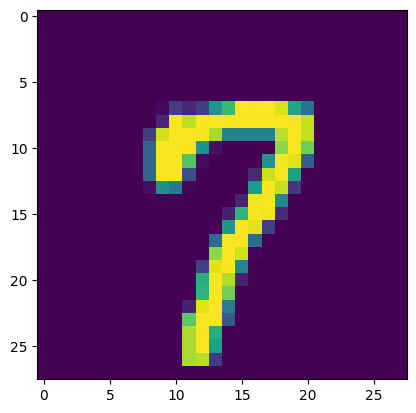

In [48]:
i = np.random.randint(0, len(X_test))
print(np.argmax(simple_3L_network.predict(X_test[i])))
plt.imshow(X_test[i].reshape(28, 28))
plt.show()

In [49]:
predictions = [
    np.argmax(simple_3L_network.predict(x)) for x in X_test]
print(classification_report([np.argmax(y) for y in y_test], predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1300
           1       0.98      0.98      0.98      1576
           2       0.96      0.95      0.96      1393
           3       0.96      0.94      0.95      1501
           4       0.95      0.96      0.96      1391
           5       0.97      0.93      0.95      1252
           6       0.95      0.98      0.96      1344
           7       0.96      0.96      0.96      1424
           8       0.96      0.96      0.96      1356
           9       0.95      0.95      0.95      1463

    accuracy                           0.96     14000
   macro avg       0.96      0.96      0.96     14000
weighted avg       0.96      0.96      0.96     14000

